## Imports and model architecture

In [ ]:
import itertools
import numpy as np
import pickle
import os
from sklearn import svm, linear_model
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
"""
Implementation of pairwise ranking using scikit-learn LinearSVC
Reference: "Large Margin Rank Boundaries for Ordinal Regression", R. Herbrich,
    T. Graepel, K. Obermayer.
Authors: Fabian Pedregosa <fabian@fseoane.net>
         Alexandre Gramfort <alexandre.gramfort@inria.fr>
"""


def transform_pairwise(X, y):
    """Transforms data into pairs with balanced labels for ranking
    Transforms a n-class ranking problem into a two-class classification
    problem. Subclasses implementing particular strategies for choosing
    pairs should override this method.
    In this method, all pairs are choosen, except for those that have the
    same target value. The output is an array of balanced classes, i.e.
    there are the same number of -1 as +1
    Parameters
    ----------
    X : array, shape (n_samples, n_features)
        The data
    y : array, shape (n_samples,) or (n_samples, 2)
        Target labels. If it's a 2D array, the second column represents
        the grouping of samples, i.e., samples with different groups will
        not be considered.
    Returns
    -------
    X_trans : array, shape (k, n_feaures)
        Data as pairs
    y_trans : array, shape (k,)
        Output class labels, where classes have values {-1, +1}
    """
    X_new = []
    y_new = []
    y = np.asarray(y)
    if y.ndim == 1:
        y = np.c_[y, np.ones(y.shape[0])]
    comb = itertools.combinations(range(X.shape[0]), 2)
    for k, (i, j) in enumerate(comb):
        if y[i, 0] == y[j, 0] or y[i, 1] != y[j, 1]:
            # skip if same target or different group
            continue
        X_new.append(X[i] - X[j])
        y_new.append(np.sign(y[i, 0] - y[j, 0]))
        # output balanced classes
        if y_new[-1] != (-1) ** k:
            y_new[-1] = - y_new[-1]
            X_new[-1] = - X_new[-1]
    return np.asarray(X_new), np.asarray(y_new).ravel()


class RankSVM(svm.LinearSVC):
    """Performs pairwise ranking with an underlying LinearSVC model
    Input should be a n-class ranking problem, this object will convert it
    into a two-class classification problem, a setting known as
    `pairwise ranking`.
    See object :ref:`svm.LinearSVC` for a full description of parameters.
    """

    def fit(self, X, y):
        """
        Fit a pairwise ranking model.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        y : array, shape (n_samples,) or (n_samples, 2)
        Returns
        -------
        self
        """
        X_trans, y_trans = transform_pairwise(X, y)
        super(RankSVM, self).fit(X_trans, y_trans)
        return self

    def predict(self, X):
        """
        Predict an ordering on X. For a list of n samples, this method
        returns a list from 0 to n-1 with the relative order of the rows of X.
        Parameters
        ----------
        X : array, shape (n_samples, n_features)
        Returns
        -------
        ord : array, shape (n_samples,)
            Returns a list of integers representing the relative order of
            the rows in X.
        """
        if hasattr(self, 'coef_'):
            np.argsort(np.dot(X, self.coef_.T))
        else:
            raise ValueError("Must call fit() prior to predict()")

    def score(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        X_trans, y_trans = transform_pairwise(X, y)
       
        return np.mean(super(RankSVM, self).predict(X_trans) == y_trans)

    def conf_matrix(self, X, y):
        """
        Because we transformed into a pairwise problem, chance level is at 0.5
        """
        #From the perspective of emotional speech as positive
        TP = 0
        TN = 0
        FN = 0
        FP = 0
        
        X_trans, y_trans = transform_pairwise(X, y)
        results = super(RankSVM, self).predict(X_trans)
        
        
        


        cf_matrix = confusion_matrix(y_trans, results)

        accuracy = np.mean(results == y_trans)

        return cf_matrix, accuracy

import seaborn as sns
def make_conf_matrix(emotion, number, out_path):
  ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', cbar=False)
  title = f"Confusion Matrix Zhu {number} for {emotion}"
  ax.set_title(title);

  ax.set_xlabel('Predictions')
  ax.set_ylabel('True Values');

  ## Ticket labels - List must be in alphabetical order
  ax.xaxis.set_ticklabels([emotion,'Neutral'])
  ax.yaxis.set_ticklabels([emotion,'Neutral'])

  plt.savefig(out_path)
  ## Display the visualization of the Confusion Matrix.
  plt.show()
         

## Training and Saving Models

In [ ]:
import pickle
emotion = "surprised"
happy_features = np.load(f'/content/drive/MyDrive/Thesis/five_{emotion}.npy', allow_pickle=True)[:2500,:384].astype('float16')
happy_labels = np.load(f'/content/drive/MyDrive/Thesis/five_{emotion}.npy', allow_pickle=True)[:2500, 384].astype('int8')
rank_svm = RankSVM().fit(happy_features, happy_labels)
filename = f'/content/drive/MyDrive/SVM Results (trained on one and five)/{emotion}_2500.sav'
pickle.dump(rank_svm, open(filename, 'wb'))

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


In [ ]:
#Example of fitting one of the Lexical Diversity models
rank_svm = RankSVM().fit(features, labels)
filename = f'/content/drive/MyDrive/Thesis/LexDiv/58773good/surprised.sav'
pickle.dump(rank_svm, open(filename, 'wb'))

## Model Evaluation

In [ ]:
happy_test_features = np.load(f'/content/drive/MyDrive/Thesis/four_happy.npy', allow_pickle=True)[:,:384].astype('float64')
happy_test_labels = np.load(f'/content/drive/MyDrive/Thesis/four_happy.npy', allow_pickle=True)[:, 384].astype('int')
angry_test_features = np.load(f'/content/drive/MyDrive/Thesis/four_angry.npy', allow_pickle=True)[:,:384].astype('float64')
angry_test_labels = np.load(f'/content/drive/MyDrive/Thesis/four_angry.npy', allow_pickle=True)[:, 384].astype('int')
sad_test_features = np.load(f'/content/drive/MyDrive/Thesis/four_sad.npy', allow_pickle=True)[:,:384].astype('float64')
sad_test_labels = np.load(f'/content/drive/MyDrive/Thesis/four_sad.npy', allow_pickle=True)[:, 384].astype('int')
surprised_test_features = np.load(f'/content/drive/MyDrive/Thesis/four_surprised.npy', allow_pickle=True)[:,:384].astype('float64')
surprised_test_labels = np.load(f'/content/drive/MyDrive/Thesis/four_surprised.npy', allow_pickle=True)[:, 384].astype('int')


In [ ]:
score_list = []
number_list = [10, 50, 100, 500, 1000, 2000, 2500]
for number in number_list:
  w_happy = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/happy_{number}.sav", 'rb'))
  score = w_happy.score(test_features, test_labels)
  print('Performance of ranking ', score)
  score_list.append(score)

Performance of ranking  0.806580147541246
Performance of ranking  0.7696828343281432
Performance of ranking  0.7142828567313693
Performance of ranking  0.9036101198572595
Performance of ranking  0.9417996191451569
Performance of ranking  0.9689875342049256
Performance of ranking  0.967391304347826


In [ ]:
import matplotlib.pyplot as plt
plt.plot(4*number_list, score_list)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Accuracy of rank svm for happy emotion")
plt.show()

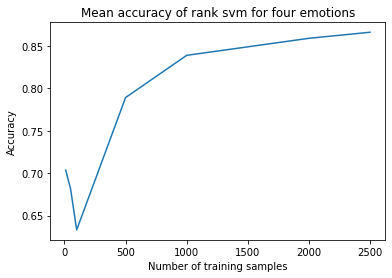

In [ ]:
import matplotlib.pyplot as plt
plt.plot(number_list, score_list)
plt.xlabel("Number of training samples")
plt.ylabel("Accuracy")
plt.title("Mean accuracy of rank svm for four emotions")
plt.show()

In [ ]:
score_list = []
emotion_list = ["happy", "angry", "sad", "surprised"]
number_list = [10, 50, 100, 500, 1000, 2000, 2500]
for number in number_list:
  for emotion in emotion_list:
    svm = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/{emotion}_{number}.sav", 'rb'))
    features = np.load(f'/content/drive/MyDrive/Thesis/four_{emotion}.npy', allow_pickle=True)[:,:384].astype('float64')
    labels = np.load(f'/content/drive/MyDrive/Thesis/four_{emotion}.npy', allow_pickle=True)[:, 384].astype('int')
    score = svm.score(features, labels)
    score_list.append(score)
print(score_list)

[0.806580147541246, 0.4531052471555904, 0.5535557120225313, 0.8405690419420396, 0.7696828343281432, 0.5471947960506313, 0.6271263061880911, 0.8222584052103503, 0.7142828567313693, 0.591985245875406, 0.6684802611576067, 0.8227144708838072, 0.9036101198572595, 0.9046582707909939, 0.8667648141332351, 0.9475684498567793, 0.9417996191451569, 0.9455001520218912, 0.8210622329615465, 0.983469619625226, 0.9689875342049256, 0.9113792386103599, 0.9035061048791025, 0.988290313805188, 0.967391304347826, 0.9602542766158326, 0.9359867820966219, 0.9893944728040838]


In [ ]:
import pickle
filename = f'/content/drive/MyDrive/SVM Results (trained on one and five)/score list happy angry sad surprised.sav'
pickle.dump(score_list, open(filename, 'wb'))

In [ ]:
happy_list = score_list[:7]
angry_list = score_list[7:14]
sad_list = score_list[14:21]
surprised_list = score_list[21:]

In [ ]:
score_list = []
sample_number_list = [40, 80, 200, 1000, 2000, 4000]
number_list = [10, 50, 100, 500, 1000, 2000]
for number in number_list:
  for emotion in emotion_list:
  w_happy = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/happy_{number}.sav", 'rb'))
  w_angry = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/angry_{number}.sav", 'rb'))
  w_sad = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/sad_{number}.sav", 'rb'))
  w_surprised = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/surprised_{number}.sav", 'rb'))
  score_happy = w_happy.score(happy_test_features, happy_test_labels)
  score_angry = w_happy.score(angry_test_features, angry_test_labels)
  score_sad = w_happy.score(sad_test_features, sad_test_labels)
  score_surprised = w_happy.score(surprised_test_features, surprised_test_labels)
  result = score_happy + score_angry + score_sad + score_surprised
  score = result/4
  score_list.append(score)
print(score_list)

[0.7036743291033909, 0.6816261541661999, 0.6332211838504744, 0.788942607735514, 0.8386627674385111, 0.8587066537581413, 0.8658436814901346]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 


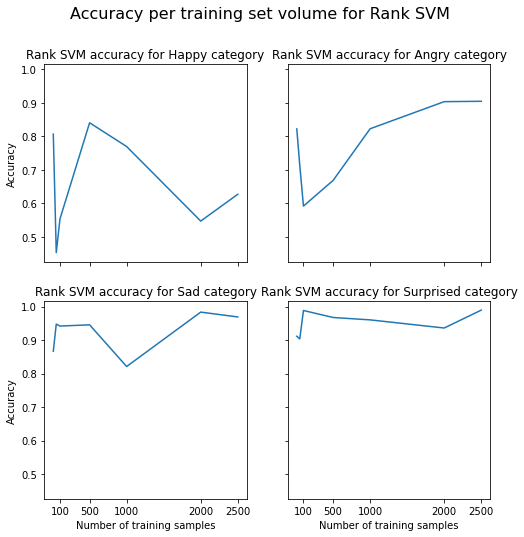

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,2, figsize = (8,8), sharey=True, sharex=True)
ax[0,0].plot(number_list, happy_list)

#ax[0,0].set_xlabel("Number of training samples")
ax[0,0].set_ylabel("Accuracy")
ax[0,0].set_xticks([100, 500, 1000, 2000, 2500])
ax[0,0].title.set_text("Rank SVM accuracy for Happy category")

ax[0,1].plot(number_list, angry_list)
#ax[0,1].set_xlabel("Number of training samples")
#ax[0,1].set_ylabel("Accuracy")
ax[0,1].title.set_text("Rank SVM accuracy for Angry category")

ax[1,0].plot(number_list, sad_list)
ax[1,0].set_xlabel("Number of training samples")
ax[1,0].set_ylabel("Accuracy")
ax[0,0].set_xticks([100, 500, 1000, 2000, 2500])

ax[1,0].title.set_text("Rank SVM accuracy for Sad category")

ax[1,1].plot(number_list, surprised_list)
ax[1,1].set_xlabel("Number of training samples")
#ax[1,1].set_ylabel("Accuracy")
ax[1,1].title.set_text("Rank SVM accuracy for Surprised category")

fig.suptitle('Accuracy per training set volume for Rank SVM', fontsize=16)

fig.tight_layout(rect=[1, 0.03, 1, 0.95])

plt.show()

Happy 2000: 96%
Angry 2000: 91%


##Lexical Diversity Evaluation

In [ ]:
score_list = []
target_folder= '/content/drive/MyDrive/Thesis/Confusion Matrices/LexDiv'

emotion_list = ["happy", "angry", "sad", "surprised"]
model_list = ['15634bad', '24992bad', '58773good', '33608good']
for model in model_list:
  for emotion in emotion_list:
    file_name = emotion + model + ".pdf"
    svm = pickle.load(open(f"/content/drive/MyDrive/Thesis/LexDiv/15634bad/{emotion}.sav", 'rb'))
    data = np.load(f'/content/drive/MyDrive/Thesis/LexDiv/9671test/{emotion}_Neutral.npy')
    feats = data[:800, :384].astype("float32")
    labels = data[:800, 384].astype("float64")
    cf_matrix, accuracy  = svm.conf_matrix(feats, labels)
    out_path = os.path.join(target_folder, file_name)
    score_list.append(accuracy)
    make_conf_matrix(emotion, model, out_path)


In [ ]:
bad_scores = score_list[:8]
good_scores = score_list[8:]

0.9270579131930317


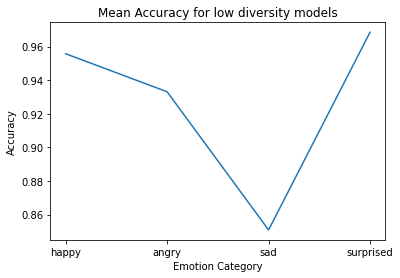

In [ ]:
import matplotlib.pyplot as plt
result_list = []
emotion_list = ["happy", "angry", "sad", "surprised"]
for i in range(4):
  result =  (bad_scores[i] + bad_scores[i+4])/2
  result_list.append(result)
print(np.mean(np.array(bad_scores)))
plt.plot(emotion_list, result_list)
plt.xlabel("Emotion Category")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy for low diversity models")
plt.show()

0.9270579131930317


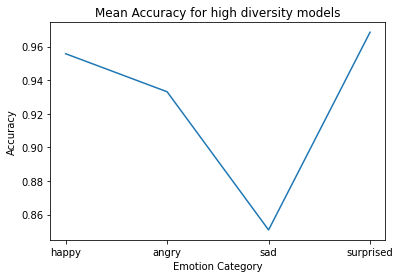

In [ ]:
import matplotlib.pyplot as plt
result_list = []
emotion_list = ["happy", "angry", "sad", "surprised"]
for i in range(4):
  result =  (good_scores[i] + good_scores[i+4])/2
  result_list.append(result)
print(np.mean(np.array(good_scores)))
plt.plot(emotion_list, result_list)
plt.xlabel("Emotion Category")
plt.ylabel("Accuracy")
plt.title("Mean Accuracy for high diversity models")
plt.show()

In [ ]:
score_list = []
target_folder= '/content/drive/MyDrive/Thesis/Confusion Matrices/LexDiv'

emotion_list = ["happy", "angry", "sad", "surprised"]

from sklearn.metrics import confusion_matrix
#For every file in test set, get all the scores
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))


import seaborn as sns

acc_list = []

for number in ['15634bad', '24992bad', '58773good', '33608good']:
#Emotion list is always in the same order, so the index is the true label
  happy = pickle.load(open(f"/content/drive/MyDrive/Thesis/LexDiv/{number}/happy.sav", 'rb'))
  angry = pickle.load(open(f"/content/drive/MyDrive/Thesis/LexDiv/{number}/angry.sav", 'rb'))
  sad = pickle.load(open(f"/content/drive/MyDrive/Thesis/LexDiv/{number}/sad.sav", 'rb'))
  surprised = pickle.load(open(f"/content/drive/MyDrive/Thesis/LexDiv/{number}/surprised.sav", 'rb'))
  for index, emotion in enumerate(emotion_list):
    happy_list= []
    angry_list = []
    sad_list = []
    surprised_list = []
    emo_lowercase = emotion.lower()
    feats = np.load(f'/content/drive/MyDrive/Thesis/four_{emo_lowercase}.npy', allow_pickle=True)[:,:384].astype('float64')
    for feat in feats:
      feat = feat.reshape(1, -1)
      happy_list.append(happy.decision_function(feat))
      angry_list.append(angry.decision_function(feat))
      sad_list.append(sad.decision_function(feat))
      surprised_list.append(surprised.decision_function(feat))

    happy_norm = NormalizeData(happy_list)
    angry_norm = NormalizeData(angry_list)
    sad_norm = NormalizeData(sad_list)
    surprised_norm = NormalizeData(surprised_list)

    result_array = np.hstack((happy_norm, angry_norm, sad_norm, surprised_norm))
    true_labels = result_array.shape[0] * [index]
    correct = 0
    predictions = []
    for row in result_array:
      if np.argmax(row) == index:
        correct+=1
        predictions.append(np.argmax(row))
    
    
    
    

    accuracy = correct/result_array.shape[0]
    print(accuracy)
    acc_list.append(accuracy)
print(acc_list)


0.284
0.129
0.351
0.103
0.067
0.454
0.242
0.217
0.378
0.353
0.25
0.077
0.135
0.274
0.238
0.17
[0.284, 0.129, 0.351, 0.103, 0.067, 0.454, 0.242, 0.217, 0.378, 0.353, 0.25, 0.077, 0.135, 0.274, 0.238, 0.17]


In [ ]:
import numpy as np
acc_one = np.mean(np.array(acc_list[:4]))
acc_two = np.mean(np.array(acc_list[4:8]))
acc_three = np.mean(np.array(acc_list[8:12]))
acc_four = np.mean(np.array(acc_list[12:16]))


In [ ]:
print(acc_one, acc_two, acc_three, acc_four)

0.21675 0.245 0.2645 0.20425000000000001


In [ ]:
y = [acc_one, acc_two, acc_three, acc_four, acc_five, acc_six]
x = sample_number_list
plt.scatter(x,y)
plt.axhline(y=0.25, color='r', linestyle='--')
plt.title("Mean Accuracy in emotion classification Zhu")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.show()

In [ ]:
happy_list = [0, 4, 8, 12, 16, 21]
angry_list = [1, 5, 9, 13, 17, 21]
sad_list = [2, 6, 10, 14, 18, 22]
surprised_list = [3, 7, 11, 15, 19, 23]
values_happy = []
values_sad = []
values_angry = []
values_surprised = []
for i in happy_list:
  values_happy.append(acc_list[i])
for i in angry_list:
  values_angry.append(acc_list[i])
for i in sad_list:
  values_sad.append(acc_list[i])
for i in surprised_list:
  values_surprised.append(acc_list[i])

fig = plt.figure()
st = fig.suptitle("Mean Accuracy per emotion Zhu", fontsize="x-large")

ax1 = fig.add_subplot(221)
ax1.scatter(x,values_happy)
plt.axhline(y=0.25, color='r', linestyle='--')
ax1.set_title("Happy")
ax1.set_ylabel("Accuracy")

ax2 = fig.add_subplot(222, sharey = ax1)
ax2.scatter(x,values_angry)
plt.axhline(y=0.25, color='r', linestyle='--')
ax2.set_title("Angry")

ax3 = fig.add_subplot(223, sharey = ax1)
ax3.scatter(x,values_sad)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Sad")
ax3.set_ylabel("Accuracy")
ax3.set_xlabel("Number of training samples")
ax3 = fig.add_subplot(224, sharey = ax1)
ax3.scatter(x,values_surprised)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Surprised")
ax3.set_xlabel("Number of training samples")
fig.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)

##Zhu Emotion-Neutral Task

In [ ]:
#All Zhu confusion matrices
import pickle
import matplotlib.pyplot as plt
import os
target_folder= '/content/drive/MyDrive/Thesis/Confusion Matrices/Zhu'
emotion_list = ["Happy", "Angry", "Sad", "Surprised"]
sample_number_list = [40, 80, 200, 1000, 2000, 4000]
model_name_list = [10, 50, 100, 500, 1000, 2000]
acc_list = []

for index, sample_number in enumerate(sample_number_list):
  for emotion in emotion_list:

    file_name = emotion + str(sample_number) + ".pdf"
    emo_lowercase = emotion.lower()
    svm = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/{emo_lowercase}_{model_name_list[index]}.sav", 'rb'))
    
    feats = np.load(f'/content/drive/MyDrive/Thesis/four_{emo_lowercase}.npy', allow_pickle=True)[:,:384].astype('float64')
    labels = np.load(f'/content/drive/MyDrive/Thesis/four_{emo_lowercase}.npy', allow_pickle=True)[:, 384].astype('int')
    
    cf_matrix, accuracy  = svm.conf_matrix(feats, labels)
    out_path = os.path.join(target_folder, file_name)
    acc_list.append(accuracy)
    make_conf_matrix(emotion, sample_number, out_path)

    del feats
    del labels
np.save(target_folder + "acclist.npy" , np.array(acc_list))

In [ ]:
import numpy as np

acc_one = np.mean(np.array(acc_list[:4]))
acc_two = np.mean(np.array(acc_list[4:8]))
acc_three = np.mean(np.array(acc_list[8:12]))
acc_four = np.mean(np.array(acc_list[12:16]))
acc_five = np.mean(np.array(acc_list[16:20]))
acc_six = np.mean(np.array(acc_list[20:]))

In [ ]:
print(acc_list)

[0.806580147541246, 0.4531052471555904, 0.5535557120225313, 0.8405690419420396, 0.7696828343281432, 0.5471947960506313, 0.6271263061880911, 0.8222584052103503, 0.7142828567313693, 0.591985245875406, 0.6684802611576067, 0.8227144708838072, 0.9036101198572595, 0.9046582707909939, 0.8667648141332351, 0.9475684498567793, 0.9417996191451569, 0.9455001520218912, 0.8210622329615465, 0.983469619625226, 0.9689875342049256, 0.9113792386103599, 0.9035061048791025, 0.988290313805188]


In [ ]:
len(acc_list)

24

In [ ]:
print(acc_one, acc_two, acc_three, acc_four, acc_five, acc_six)

0.6634525371653518 0.6915655854443039 0.6993657086620473 0.905650413659567 0.9229579059384552 0.943040797874894


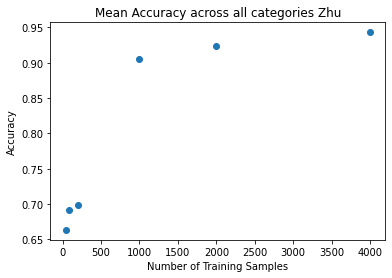

In [ ]:
y = [acc_one, acc_two, acc_three, acc_four, acc_five, acc_six]
x = sample_number_list
plt.scatter(x,y)
plt.title("Mean Accuracy across all categories Zhu")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.show()

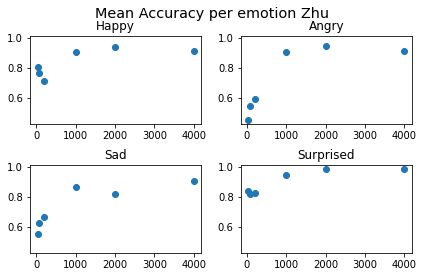

In [ ]:
happy_list = [0, 4, 8, 12, 16, 21]
angry_list = [1, 5, 9, 13, 17, 21]
sad_list = [2, 6, 10, 14, 18, 22]
surprised_list = [3, 7, 11, 15, 19, 23]
values_happy = []
values_sad = []
values_angry = []
values_surprised = []
for i in happy_list:
  values_happy.append(acc_list[i])
for i in angry_list:
  values_angry.append(acc_list[i])
for i in sad_list:
  values_sad.append(acc_list[i])
for i in surprised_list:
  values_surprised.append(acc_list[i])

fig = plt.figure()
st = fig.suptitle("Mean Accuracy Emotional-Neutral task Zhu", fontsize="x-large")

ax1 = fig.add_subplot(221)
ax1.scatter(x,values_happy)
plt.axhline(y=0.25, color='r', linestyle='--')
ax1.set_title("Happy")
ax1.set_ylabel("Accuracy")

ax2 = fig.add_subplot(222, sharey = ax1)
ax2.scatter(x,values_angry)
plt.axhline(y=0.25, color='r', linestyle='--')
ax2.set_title("Angry")

ax3 = fig.add_subplot(223, sharey = ax1)
ax3.scatter(x,values_sad)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Sad")
ax3.set_ylabel("Accuracy")
ax3.set_xlabel("Number of training samples")
ax3 = fig.add_subplot(224, sharey = ax1)
ax3.scatter(x,values_surprised)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Surprised")
ax3.set_xlabel("Number of training samples")
fig.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)



##Zhu Emotion Task

In [ ]:

from sklearn.metrics import confusion_matrix,
#For every file in test set, get all the scores
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))
target_folder= '/content/drive/MyDrive/Thesis/Confusion Matrices/Zhu/emo'

import seaborn as sns

acc_list = []

for number in [10, 50, 100, 500, 1000, 2000]:
#Emotion list is always in the same order, so the index is the true label
  happy = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/happy_{number}.sav", 'rb'))
  angry = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/angry_{number}.sav", 'rb'))
  sad = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/sad_{number}.sav", 'rb'))
  surprised = pickle.load(open(f"/content/drive/MyDrive/SVM Results (trained on one and five)/surprised_{number}.sav", 'rb'))
  
  for index, emotion in enumerate(emotion_list):
    happy_list= []
    angry_list = []
    sad_list = []
    surprised_list = []
    emo_lowercase = emotion.lower()
    feats = np.load(f'/content/drive/MyDrive/Thesis/four_{emo_lowercase}.npy', allow_pickle=True)[:,:384].astype('float64')
    for feat in feats:
      feat = feat.reshape(1, -1)
      happy_list.append(happy.decision_function(feat))
      angry_list.append(angry.decision_function(feat))
      sad_list.append(sad.decision_function(feat))
      surprised_list.append(surprised.decision_function(feat))

    happy_norm = NormalizeData(happy_list)
    angry_norm = NormalizeData(angry_list)
    sad_norm = NormalizeData(sad_list)
    surprised_norm = NormalizeData(surprised_list)

    result_array = np.hstack((happy_norm, angry_norm, sad_norm, surprised_norm))
    true_labels = result_array.shape[0] * [index]
    correct = 0
    predictions = []
    for row in result_array:
      if np.argmax(row) == index:
        correct+=1
        predictions.append(np.argmax(row))
    labels = [index] * result_array.shape[0]
    cf_matrix = confusion_matrix(labels, predictions)
    
    

    accuracy = correct/result_array.shape[0]
    print(accuracy)
    acc_list.append(accuracy)
#print(acc_list)

0.426
0.045
0.218
0.2
0.226
0.304
0.22
0.11
0.065
0.136
0.425
0.307
0.211
0.213
0.309
0.212
0.119
0.042
0.447
0.216
0.305
0.197
0.382
0.059


Accuracies: 0.426
0.045
0.218
0.2
0.226
0.304
0.22
0.11
0.065
0.136
0.425
0.307
0.211
0.213
0.309
0.212
0.119
0.042
0.447
0.216
0.305
0.197
0.382
0.059

In [ ]:
import numpy as np
acc_one = np.mean(np.array(acc_list[:4]))
acc_two = np.mean(np.array(acc_list[4:8]))
acc_three = np.mean(np.array(acc_list[8:12]))
acc_four = np.mean(np.array(acc_list[12:16]))
acc_five = np.mean(np.array(acc_list[16:20]))
acc_six = np.mean(np.array(acc_list[20:]))

In [ ]:
print(acc_one, acc_two, acc_three, acc_four, acc_five, acc_six)

0.22225 0.215 0.23325 0.23625 0.206 0.23575000000000002


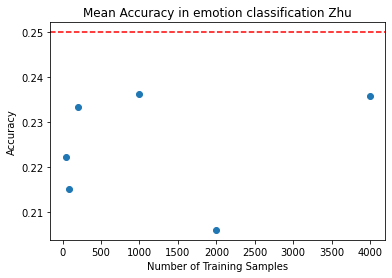

In [ ]:
y = [acc_one, acc_two, acc_three, acc_four, acc_five, acc_six]
x = sample_number_list
plt.scatter(x,y)
plt.axhline(y=0.25, color='r', linestyle='--')
plt.title("Mean Accuracy in emotion classification Zhu")
plt.xlabel("Number of Training Samples")
plt.ylabel("Accuracy")
plt.show()

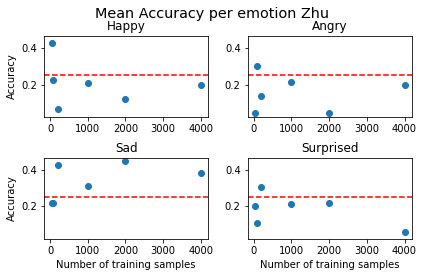

In [ ]:
happy_list = [0, 4, 8, 12, 16, 21]
angry_list = [1, 5, 9, 13, 17, 21]
sad_list = [2, 6, 10, 14, 18, 22]
surprised_list = [3, 7, 11, 15, 19, 23]
values_happy = []
values_sad = []
values_angry = []
values_surprised = []
for i in happy_list:
  values_happy.append(acc_list[i])
for i in angry_list:
  values_angry.append(acc_list[i])
for i in sad_list:
  values_sad.append(acc_list[i])
for i in surprised_list:
  values_surprised.append(acc_list[i])

fig = plt.figure()
st = fig.suptitle("Mean Accuracy per emotion Zhu", fontsize="x-large")

ax1 = fig.add_subplot(221)
ax1.scatter(x,values_happy)
plt.axhline(y=0.25, color='r', linestyle='--')
ax1.set_title("Happy")
ax1.set_ylabel("Accuracy")

ax2 = fig.add_subplot(222, sharey = ax1)
ax2.scatter(x,values_angry)
plt.axhline(y=0.25, color='r', linestyle='--')
ax2.set_title("Angry")

ax3 = fig.add_subplot(223, sharey = ax1)
ax3.scatter(x,values_sad)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Sad")
ax3.set_ylabel("Accuracy")
ax3.set_xlabel("Number of training samples")
ax3 = fig.add_subplot(224, sharey = ax1)
ax3.scatter(x,values_surprised)
plt.axhline(y=0.25, color='r', linestyle='--')
ax3.set_title("Surprised")
ax3.set_xlabel("Number of training samples")
fig.tight_layout()

# shift subplots down:
st.set_y(0.95)
fig.subplots_adjust(top=0.85)